In [58]:
import pandas as pd
import sklearn
import re
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")

## Содержание:
+ Предварительный анализ данных
    + Удаление пропущенных значений
+ Подготовка данных
    + Кодирование текстовых полей
    + Корреляции
    + Масштабирование
+ Обучение
    + Выбор моделей
    + Последовательные GridSearch'ы по параметрам
    + Оценка качества

### Предварительный анализ данных

In [2]:
X_raw = pd.read_csv("cars_train.csv")

In [3]:
X_raw.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0


In [4]:
X_raw.shape

(6999, 13)

In [5]:
# Пропущенные значения
for column in X_raw.columns:
    if X_raw[column].isna().sum() != 0:
        print(column, X_raw[column].isna().sum())

mileage 202
engine 202
max_power 196
torque 203
seats 202


In [6]:
# Доля объектов с пропущенными значениями небольшая - удаляем
X_clean = X_raw.dropna()

In [7]:
X_clean.shape # (большинство удаленных объектов имели более одного пропущенного значения)

(6796, 13)

In [8]:
for column in ['mileage', 'engine', 'max_power']:
    X_clean[column] = (X_clean[column].apply(lambda x: x.split()[0])).astype(float)

In [9]:
# Возможные значения строковых признаков
for column in X_clean.columns:
    if X_clean[column].dtype == 'object':
        print(column, len(set(X_clean[column])))
        print(X_clean[column].value_counts())
        print()

name 1852
Maruti Swift Dzire VDI                          116
Maruti Alto 800 LXI                              66
Maruti Alto LXi                                  61
BMW X4 M Sport X xDrive20d                       54
Maruti Swift VDI                                 51
                                               ... 
Nissan Micra Active XV                            1
Maruti Wagon R AX BSIV                            1
Renault Koleos 2.0 Diesel                         1
Hyundai Grand i10 Magna AT                        1
Toyota Innova 2.5 GX (Diesel) 8 Seater BS IV      1
Name: name, Length: 1852, dtype: int64

fuel 4
Diesel    3696
Petrol    3022
CNG         47
LPG         31
Name: fuel, dtype: int64

seller_type 3
Individual          5640
Dealer               950
Trustmark Dealer     206
Name: seller_type, dtype: int64

transmission 2
Manual       5900
Automatic     896
Name: transmission, dtype: int64

owner 5
First Owner             4518
Second Owner            1711
Third Owner 

In [10]:
X_clean.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75nm@ 4000rpm,5.0


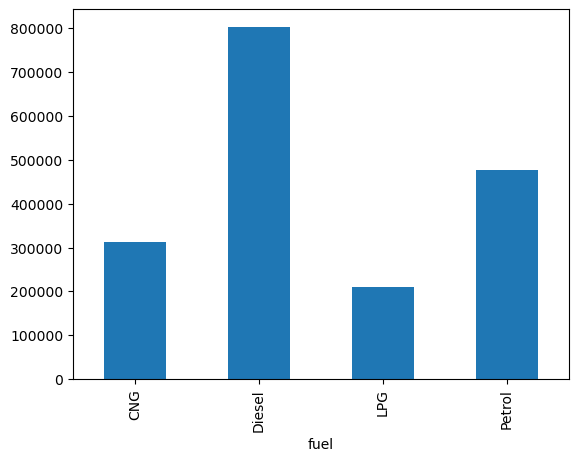

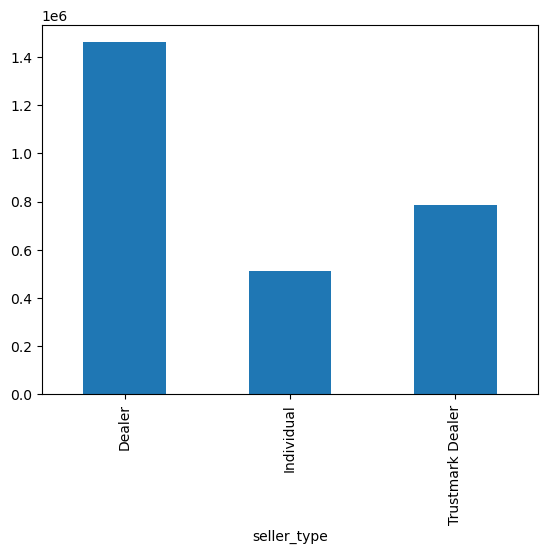

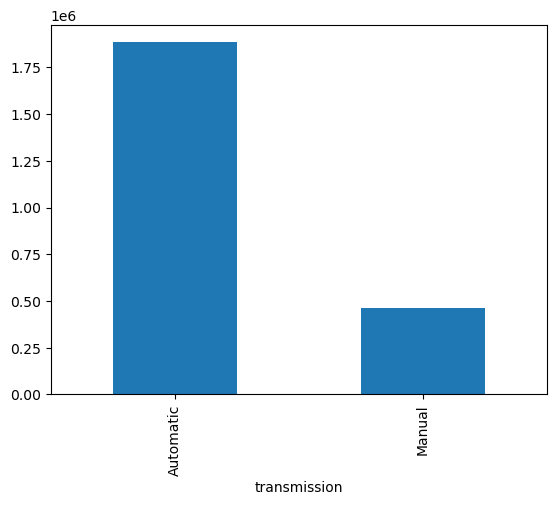

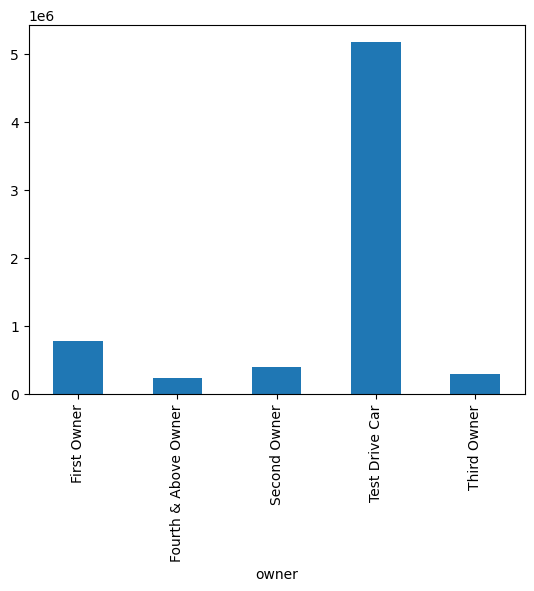

In [11]:
for column in X_clean.columns:
    if X_clean[column].dtype == 'object' and len(set(X_clean[column])) < 20:
        plt.figure()
        (X_clean.groupby(column)['selling_price'].mean()).plot(kind = "bar")

**Вывод:**

Поля fuel, seller_type, transmission - небольшой диапазон значений, можно делать one-hot encoding.

Поле owner логичнее кодировать порядковыми номерами (по увеличению числа владельцев).

Все вышеперечисленные поля достаточно хорошо коррелируют с ценой.

Поле torque - необходимы преобразования для извлечения числовых признаков.

Поле name имеет слишком много различных значений, многое встречаются в небольшом количестве (единственном числе) - удаляем.

### Подготовка данных

In [12]:
X_clean = X_clean.drop(['name'], axis=1)
X_clean['owner'] = X_clean['owner'].map({'Test Drive Car': 0, 'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 'Fourth & Above Owner': 4})

In [13]:
X_clean.head()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
3,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0
4,2017,440000,45000,Petrol,Individual,Manual,1,20.14,1197.0,81.86,113.75nm@ 4000rpm,5.0


In [14]:
X_clean['torque'][:20]
# Два параметра - nm и rpm
# nm может задаваться через kgm (приставка kilo - нужно умножать на 1000), rpm может задаваться диапазоном

0               190Nm@ 2000rpm
1          250Nm@ 1500-2500rpm
2     22.4 kgm at 1750-2750rpm
3        11.5@ 4,500(kgm@ rpm)
4            113.75nm@ 4000rpm
5         7.8@ 4,500(kgm@ rpm)
6                59Nm@ 2500rpm
7          170Nm@ 1800-2400rpm
8               160Nm@ 2000rpm
9               248Nm@ 2250rpm
10               78Nm@ 4500rpm
11              190Nm@ 2000rpm
13               84Nm@ 3500rpm
14         115Nm@ 3500-3600rpm
15    22.4 kgm at 1750-2750rpm
16               62Nm@ 3000rpm
17       219.7Nm@ 1500-2750rpm
18              160Nm@ 2000rpm
19              200Nm@ 1750rpm
20              190Nm@ 2000rpm
Name: torque, dtype: object

In [15]:
# Названия параметров могут отсутствовать, но по смыслу первый параметр - nm (не kgm)
num_values = set()
for i in range(X_clean.shape[0]):
    string = X_clean['torque'].loc[X_clean.index[i]].lower()
    if string.find('nm') == -1 and string.find('kgm') == -1:
        print(X_clean['torque'].loc[X_clean.index[i]])

250@ 1250-5000rpm
510@ 1600-2400
250@ 1250-5000rpm
210 / 1900
510@ 1600-2400
210 / 1900
210 / 1900
210 / 1900
210 / 1900
210 / 1900
210 / 1900


In [16]:
X_clean['torque'] = (X_clean['torque'].apply(lambda x: x.replace(',', '.'))) # заменим запятые на точки для удобства

In [17]:
# Возможное количество чисел
num_values = set()
for i in range(X_clean.shape[0]):
    num_values.add(len(re.findall(r'[\d.]*\d+', X_clean['torque'].loc[X_clean.index[i]])))
print(num_values)

{1, 2, 3}


In [18]:
for i in range(X_clean.shape[0]):
    if len(re.findall(r'[\d.]*\d+', X_clean['torque'].loc[X_clean.index[i]])) == 1:
        print(X_clean['torque'].loc[X_clean.index[i]])
# Если число только одно - это первый параметр (nm)

400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm
400Nm


In [19]:
# Извлечение первого параметра
def first_param(x):
    value = float(re.findall(r'[\d.]*\d+', x)[0])
    if x.lower().find('kgm') != -1:
        value *= 1000
    return value

In [20]:
# Извлечение второго параметра (если его нет - NaN, если задан диапазон - берется среднее)
def second_param(x):
    values = re.findall(r'[\d.]*\d+', x)
    for i in range(1, len(values)):
        values[i] = values[i].replace('.', '') # точки могут стоять как разделитель после тысячи - убрать
    if len(values) == 2:
        return float(values[1])
    elif len(values) == 3:
        return (float(values[1]) + float(values[2])) / 2
    else: return None

In [21]:
X_clean['torque1'] = (X_clean['torque'].apply(lambda x: first_param(x))).astype(float)
X_clean['torque2'] = (X_clean['torque'].apply(lambda x: second_param(x))).astype(float)

In [22]:
X_clean.head(10)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,torque1,torque2
0,2014,450000,145500,Diesel,Individual,Manual,1,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0,190.00,2000.0
1,2014,370000,120000,Diesel,Individual,Manual,2,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0,250.00,2000.0
2,2010,225000,127000,Diesel,Individual,Manual,1,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0,22400.00,2250.0
3,2007,130000,120000,Petrol,Individual,Manual,1,16.10,1298.0,88.20,11.5@ 4.500(kgm@ rpm),5.0,11500.00,4500.0
4,2017,440000,45000,Petrol,Individual,Manual,1,20.14,1197.0,81.86,113.75nm@ 4000rpm,5.0,113.75,4000.0
5,2007,96000,175000,LPG,Individual,Manual,1,17.30,1061.0,57.50,7.8@ 4.500(kgm@ rpm),5.0,7800.00,4500.0
6,2001,45000,5000,Petrol,Individual,Manual,2,16.10,796.0,37.00,59Nm@ 2500rpm,4.0,59.00,2500.0
7,2011,350000,90000,Diesel,Individual,Manual,1,23.59,1364.0,67.10,170Nm@ 1800-2400rpm,5.0,170.00,2100.0
8,2013,200000,169000,Diesel,Individual,Manual,1,20.00,1399.0,68.10,160Nm@ 2000rpm,5.0,160.00,2000.0
9,2014,500000,68000,Diesel,Individual,Manual,2,19.01,1461.0,108.45,248Nm@ 2250rpm,5.0,248.00,2250.0


In [23]:
X_clean = X_clean.drop('torque', axis=1)
X_clean = pd.get_dummies(X_clean, drop_first=True)

In [24]:
X_clean.head()

,year,selling_price,km_driven,owner,mileage,engine,max_power,seats,torque1,torque2,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual
0,2014,450000,145500,1,23.40,1248.0,74.00,5.0,190.00,2000.0,1,0,0,1,0,1
1,2014,370000,120000,2,21.14,1498.0,103.52,5.0,250.00,2000.0,1,0,0,1,0,1
2,2010,225000,127000,1,23.00,1396.0,90.00,5.0,22400.00,2250.0,1,0,0,1,0,1
3,2007,130000,120000,1,16.10,1298.0,88.20,5.0,11500.00,4500.0,0,0,1,1,0,1
4,2017,440000,45000,1,20.14,1197.0,81.86,5.0,113.75,4000.0,0,0,1,1,0,1


In [25]:
X_clean['torque2'].isna().sum() # объекты с отсутствующим вторым параметром torque; мало - удаляем

28

In [26]:
X_clean = X_clean.dropna()

In [27]:
y = X_clean['selling_price']
X = X_clean.drop('selling_price', axis=1)

In [28]:
X.corrwith(y)

year                            0.405311
km_driven                      -0.212367
owner                          -0.233217
mileage                        -0.122567
engine                          0.454429
max_power                       0.739855
seats                           0.047386
torque1                        -0.053992
torque2                        -0.125698
fuel_Diesel                     0.194066
fuel_LPG                       -0.036711
fuel_Petrol                    -0.183764
seller_type_Individual         -0.401115
seller_type_Trustmark Dealer    0.033180
transmission_Manual            -0.573015
dtype: float64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [30]:
normalizer = preprocessing.StandardScaler().fit(X_train)
columns = X.columns
X_train = pd.DataFrame(data=normalizer.transform(X_train))
X_test = pd.DataFrame(data=normalizer.transform(X_test))
X_train.columns = columns
X_test.columns = columns
X_train.head()

,year,km_driven,owner,mileage,engine,max_power,seats,torque1,torque2,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual
0,0.527159,0.161058,0.813715,-0.843352,1.467083,1.426870,1.630883,-0.131828,-0.667523,0.908147,-0.06985,-0.885540,0.450439,-0.167982,-2.658918
1,0.268922,0.807379,0.813715,0.056402,0.263234,1.027858,-0.437245,-0.138732,-0.542678,0.908147,-0.06985,-0.885540,0.450439,-0.167982,0.376093
2,0.010685,-0.856897,-0.624020,-0.205924,-0.513117,-0.255052,-0.437245,-0.153031,1.130242,-1.101144,-0.06985,1.129255,0.450439,-0.167982,0.376093
3,-0.247552,1.162855,0.813715,0.921832,-0.410276,-0.483183,-0.437245,-0.145615,-0.867274,0.908147,-0.06985,-0.885540,0.450439,-0.167982,0.376093
4,1.301871,-0.776107,-0.624020,-0.843352,-0.168296,2.005148,-0.437245,-0.139707,-0.742429,-1.101144,-0.06985,1.129255,-2.220059,-0.167982,-2.658918


**Выводы:** по корреляции: важнее всего year, engine, max_power, seller_type, transmission.

### Обучение

Используемые модели: линейная регрессия (Lasso) и градиентный бустинг.

Регрессионные модели: линейная регрессия (обычная, Ridge, Lasso), случайный лес / градиентный бустинг.

Линейная регрессия: используется Lasso, так как данная модель за счет L1 регуляризации лучше зануляет незначимые признаки (которых достаточно много по корреляции).

Случайный лес / градиентный бустинг: у бустинга более высокий результат на сложных данных (уменьшение смещения), но нужно избегать переобучения. В качестве бустинга берется XGBoost.

**Оценка качества:** используется RMSE, MAPE и MAE - для ошибки в числах и в процентах; в числах - как корень из квадрата и модуль ошибки.

**Линейная регрессия**

In [31]:
lasso = Lasso()

In [33]:
param_test1 = {
    'alpha': [0.01, 0.1, 1, 10, 100, 1000],
    'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}

gsearch1 = GridSearchCV(estimator=lasso, 
                        param_grid=param_test1,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train, y_train)

gsearch1.best_params_

{'alpha': 1000, 'tol': 0.0001}

In [34]:
lasso.set_params(**gsearch1.best_params_)

Lasso(alpha=1000)

In [35]:
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)

**Градиентный бустинг**

In [36]:
gb = XGBRegressor()

In [38]:
param_test1 = {
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'n_estimators': [100, 200, 300, 400]
}

gsearch1 = GridSearchCV(estimator=gb, 
                        param_grid=param_test1,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train, y_train)

gsearch1.best_params_

{'learning_rate': 0.1, 'n_estimators': 400}

In [39]:
gb.set_params(**gsearch1.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
param_test2 = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_child_weight': [1, 2, 3, 4, 5]
}

gsearch2 = GridSearchCV(estimator=gb, 
                        param_grid=param_test2,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1,
                        cv=5)

gsearch2.fit(X_train, y_train)

gsearch2.best_params_

{'max_depth': 5, 'min_child_weight': 2}

In [41]:
gb.set_params(**gsearch2.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
param_test3 = {
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1]
}

gsearch3 = GridSearchCV(estimator=gb, 
                        param_grid=param_test3,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1,
                        cv=5)

gsearch3.fit(X_train, y_train)

gsearch3.best_params_

{'colsample_bytree': 1, 'subsample': 0.9}

In [43]:
gb.set_params(**gsearch3.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [44]:
param_test4 = {
    'gamma': [0.01, 0.1, 0.25, 0.5, 0.75, 1],
    'reg_alpha': [1e-7, 1e-6, 1e-4, 1e-2, 1]
}

gsearch4 = GridSearchCV(estimator=gb, 
                        param_grid=param_test4,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1,
                        cv=5)

gsearch4.fit(X_train, y_train)

gsearch4.best_params_

{'gamma': 0.01, 'reg_alpha': 0.01}

In [45]:
gb.set_params(**gsearch4.best_params_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.01, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [46]:
gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test)

**Оценка качества:** используется RMSE, MAPE и MAE - для ошибки в числах и в процентах; в числах - как корень из квадрата и модуль ошибки.

In [59]:
print('Linear regression RMSE:', mean_squared_error(y_test, lasso.predict(X_test))**(1/2))
print('Gradient boosting RMSE:', mean_squared_error(pred_gb, y_test)**(1/2))

Linear regression RMSE: 457586.2780239868
Gradient boosting RMSE: 178142.21954355628


In [60]:
print('Linear regression MAPE:', mean_absolute_percentage_error(y_test, lasso.predict(X_test)))
print('Gradient boosting MAPE:', mean_absolute_percentage_error(pred_gb, y_test))

Linear regression MAPE: 0.6907812801204838
Gradient boosting MAPE: 0.13794304948859848


In [62]:
print('Linear regression MAE:', mean_absolute_error(y_test, lasso.predict(X_test)))
print('Gradient boosting MAE:', mean_absolute_error(pred_gb, y_test))

Linear regression MAE: 264225.5162832613
Gradient boosting MAE: 68734.6572097335


**Вывод**: градиентный бустинг значительно превосходит линейную регрессию.